Contents:<br>
- Setup
- Preprocessing Data
- ResNet101
 - Feature Extraction from pre-trained model
 - Fine-tuning of pre-trained model
 - Results
- VGG16
 - Feature Extraction from pre-trained model
 - Fine-tuning of pre-trained model
 - Results
- Comparison of ResNet101 and VGG16

## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/'My Drive'/CMI/sem-4/CV/data/data

[Errno 2] No such file or directory: 'drive/My Drive/CMI/sem-4/CV/data/data'
/content/drive/My Drive/CMI/sem-4/CV


In [ ]:
ls

test/  train/


In [ ]:
#!mkdir data
#!unzip 'data.zip' -d 'data/'

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Preprocessing Data

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split=0.33)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory('train',target_size=(224,224),batch_size=32,
                                                    class_mode='categorical',shuffle=True,subset='training')
valid_generator = train_datagen.flow_from_directory('train',target_size=(224,224),batch_size=32,
                                                    class_mode='categorical',shuffle=True,subset='validation')
test_generator = test_datagen.flow_from_directory('test',target_size=(224,224),batch_size=32,class_mode='categorical')

Found 3630 images belonging to 15 classes.
Found 1770 images belonging to 15 classes.
Found 1800 images belonging to 15 classes.


## ResNet101

#### Feature extraction model
This has a ResNet101 pre-trained model with all layers frozen. Its output is flattened and a classification layer is added after that.

In [ ]:
resnet101 = tf.keras.applications.resnet.ResNet101(include_top=False, weights='imagenet', input_shape=(224,224,3))
resnet101.trainable=False

In [ ]:
resnet_base = tf.keras.models.Sequential()
resnet_base.add(resnet101)
resnet_base.add(tf.keras.layers.Flatten())
resnet_base.add(tf.keras.layers.Dropout(0.4))
resnet_base.add(tf.keras.layers.Dense(15, activation='softmax'))
resnet_base.compile(loss=tf.keras.losses.categorical_crossentropy,
                    optimizer=tf.keras.optimizers.Adamax(lr=0.0001),metrics=['accuracy'])
resnet_base.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Model)            (None, 7, 7, 2048)        42658176  
_________________________________________________________________
flatten_7 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 100352)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 15)                1505295   
Total params: 44,163,471
Trainable params: 1,505,295
Non-trainable params: 42,658,176
_________________________________________________________________


In [ ]:
resnet_base_hist = resnet_base.fit_generator(train_generator,validation_data=valid_generator,epochs=30,
                                       steps_per_epoch=114,validation_steps=56)

Epoch 1/30
114/114 [==============================] - 122s 1s/step - loss: 2.8910 - accuracy: 0.1017 - val_loss: 2.3922 - val_accuracy: 0.2141
Epoch 2/30
114/114 [==============================] - 123s 1s/step - loss: 2.6393 - accuracy: 0.1543 - val_loss: 2.2583 - val_accuracy: 0.2463
Epoch 3/30
114/114 [==============================] - 118s 1s/step - loss: 2.5138 - accuracy: 0.1837 - val_loss: 2.1663 - val_accuracy: 0.3271
Epoch 4/30
114/114 [==============================] - 121s 1s/step - loss: 2.3823 - accuracy: 0.2146 - val_loss: 2.1286 - val_accuracy: 0.3299
Epoch 5/30
114/114 [==============================] - 119s 1s/step - loss: 2.3315 - accuracy: 0.2278 - val_loss: 2.0661 - val_accuracy: 0.3277
Epoch 6/30
114/114 [==============================] - 123s 1s/step - loss: 2.2097 - accuracy: 0.2636 - val_loss: 2.0440 - val_accuracy: 0.3412
Epoch 7/30
114/114 [==============================] - 124s 1s/step - loss: 2.1919 - accuracy: 0.2813 - val_loss: 1.9693 - val_accuracy: 0.3678

In [ ]:
_, resnet_base_valid_acc = resnet_base.evaluate(valid_generator,steps=57)
print('ResNet101 Base model validation accuracy: %.4f' % resnet_base_valid_acc)

57/57 [==============================] - 26s 455ms/step - loss: 1.7014 - accuracy: 0.4623
ResNet101 Base model validation accuracy: 0.4623


#### Fine-Tuning model
Here we unfreeze a portion of the ResNet101 model.

In [ ]:
resnet101 = tf.keras.applications.resnet.ResNet101(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in resnet101.layers[:-60]:
  layer.trainable = False
# By default, all the layers are trainable. So they have to be specified as not trainable.

In [ ]:
resnet_fine_tuned = tf.keras.models.Sequential()
resnet_fine_tuned.add(resnet101)
resnet_fine_tuned.add(tf.keras.layers.Flatten())
resnet_fine_tuned.add(tf.keras.layers.Dropout(0.5))
resnet_fine_tuned.add(tf.keras.layers.Dense(15, activation='softmax'))
resnet_fine_tuned.compile(loss=tf.keras.losses.categorical_crossentropy,
                    optimizer=tf.keras.optimizers.Adamax(lr=0.0001),metrics=['accuracy'])
resnet_fine_tuned.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Model)            (None, 7, 7, 2048)        42658176  
_________________________________________________________________
flatten_12 (Flatten)         (None, 100352)            0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 100352)            0         
_________________________________________________________________
dense_17 (Dense)             (None, 15)                1505295   
Total params: 44,163,471
Trainable params: 19,574,543
Non-trainable params: 24,588,928
_________________________________________________________________


In [ ]:
resnet_fine_tuned_hist = resnet_fine_tuned.fit_generator(train_generator,validation_data=valid_generator,
                                                         epochs=20,steps_per_epoch=114,validation_steps=56)

Epoch 1/20
114/114 [==============================] - 133s 1s/step - loss: 2.8323 - accuracy: 0.2631 - val_loss: 2.7299 - val_accuracy: 0.1175
Epoch 2/20
114/114 [==============================] - 126s 1s/step - loss: 1.9919 - accuracy: 0.3931 - val_loss: 2.2570 - val_accuracy: 0.2621
Epoch 3/20
114/114 [==============================] - 124s 1s/step - loss: 1.5532 - accuracy: 0.4978 - val_loss: 1.6580 - val_accuracy: 0.4661
Epoch 4/20
114/114 [==============================] - 124s 1s/step - loss: 1.3416 - accuracy: 0.5598 - val_loss: 1.5950 - val_accuracy: 0.4718
Epoch 5/20
114/114 [==============================] - 120s 1s/step - loss: 1.1581 - accuracy: 0.6069 - val_loss: 1.6893 - val_accuracy: 0.4904
Epoch 6/20
114/114 [==============================] - 124s 1s/step - loss: 1.0430 - accuracy: 0.6507 - val_loss: 1.5929 - val_accuracy: 0.4768
Epoch 7/20
114/114 [==============================] - 121s 1s/step - loss: 0.8541 - accuracy: 0.7033 - val_loss: 1.5518 - val_accuracy: 0.5023

In [ ]:
_, resnet_fine_tuned_valid_acc = resnet_fine_tuned.evaluate(valid_generator,steps=57)
print('ResNet101 Fine tuned model validation accuracy: %.4f' % resnet_fine_tuned_valid_acc)

57/57 [==============================] - 25s 435ms/step - loss: 1.8539 - accuracy: 0.5450
ResNet101 Fine tuned model validation accuracy: 0.5450


#### Results
<br>Test Accuracy of ResNet101 Base and Fine tuned models.<br>
Resnet101 base model - 44.8% test acc<br>
Resnet101 Fine tuned - 54.4% test acc

In [ ]:
_, resnet_base_acc = resnet_base.evaluate(test_generator,steps=57)
print('ResNet101 Base model test accuracy: %.4f' % resnet_base_acc)

57/57 [==============================] - 39s 685ms/step - loss: 1.6608 - accuracy: 0.4483
ResNet101 Base model test accuracy: 0.4483


In [ ]:
_, resnet_fine_tuned_acc = resnet_fine_tuned.evaluate(test_generator,steps=57)
print('ResNet101 Fine tuned model test accuracy: %.4f' % resnet_fine_tuned_acc)

57/57 [==============================] - 42s 735ms/step - loss: 1.7876 - accuracy: 0.5444
ResNet101 Fine tuned model test accuracy: 0.5444


<br>Loss and Accuracy plots of Feature extraction (base) model and Fine tuned model.

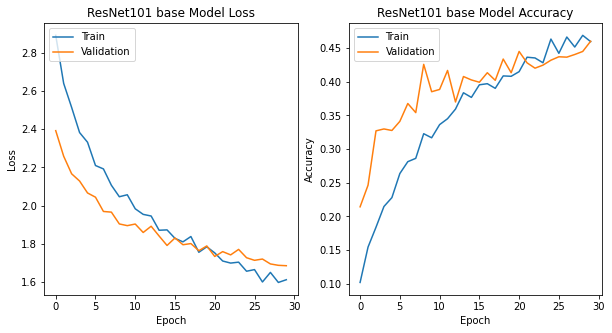

In [ ]:
# Loss and Accuracy plots of ResNet101 Base model
fig = plt.gcf()
fig.set_size_inches(10,5)
plt.subplot(1,2,1)
plt.plot(resnet_base_hist.history['loss'])
plt.plot(resnet_base_hist.history['val_loss'])
plt.title('ResNet101 base Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplot(1,2,2)
plt.plot(resnet_base_hist.history['accuracy'])
plt.plot(resnet_base_hist.history['val_accuracy'])
plt.title('ResNet101 base Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

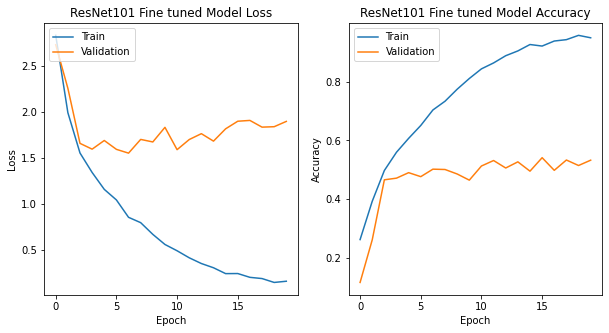

In [ ]:
# Loss and Accuracy plots of ResNet101 Fine tuned model
fig = plt.gcf()
fig.set_size_inches(10,5)
plt.subplot(1,2,1)
plt.plot(resnet_fine_tuned_hist.history['loss'])
plt.plot(resnet_fine_tuned_hist.history['val_loss'])
plt.title('ResNet101 Fine tuned Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplot(1,2,2)
plt.plot(resnet_fine_tuned_hist.history['accuracy'])
plt.plot(resnet_fine_tuned_hist.history['val_accuracy'])
plt.title('ResNet101 Fine tuned Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## VGG16

#### Fearure extraction model
This has a VGG16 pre-trained model with all layers frozen. Its output is flattened, a classification layer is added after that.

In [ ]:
vgg16 = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))
vgg16.trainable = False

In [ ]:
vgg16_model = tf.keras.models.Sequential()
vgg16_model.add(vgg16)
vgg16_model.add(tf.keras.layers.Flatten())
vgg16_model.add(tf.keras.layers.Dropout(0.5))
vgg16_model.add(tf.keras.layers.Dense(15, activation='softmax'))
vgg16_model.compile(loss=tf.keras.losses.categorical_crossentropy,
                    optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),metrics=['accuracy'])
vgg16_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 25088)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 15)                376335    
Total params: 15,091,023
Trainable params: 376,335
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
vgg16_hist = vgg16_model.fit_generator(train_generator,validation_data=valid_generator,epochs=20,
                                       steps_per_epoch=114,validation_steps=56)

Epoch 1/20
114/114 [==============================] - 117s 1s/step - loss: 1.8869 - accuracy: 0.4039 - val_loss: 1.1487 - val_accuracy: 0.7237
Epoch 2/20
114/114 [==============================] - 118s 1s/step - loss: 1.0002 - accuracy: 0.7072 - val_loss: 0.8004 - val_accuracy: 0.7847
Epoch 3/20
114/114 [==============================] - 117s 1s/step - loss: 0.6951 - accuracy: 0.7920 - val_loss: 0.6764 - val_accuracy: 0.8113
Epoch 4/20
114/114 [==============================] - 115s 1s/step - loss: 0.5536 - accuracy: 0.8300 - val_loss: 0.6594 - val_accuracy: 0.7966
Epoch 5/20
114/114 [==============================] - 116s 1s/step - loss: 0.4632 - accuracy: 0.8656 - val_loss: 0.5737 - val_accuracy: 0.8277
Epoch 6/20
114/114 [==============================] - 116s 1s/step - loss: 0.3854 - accuracy: 0.8901 - val_loss: 0.5708 - val_accuracy: 0.8181
Epoch 7/20
114/114 [==============================] - 116s 1s/step - loss: 0.3168 - accuracy: 0.9127 - val_loss: 0.5250 - val_accuracy: 0.8305

In [ ]:
_, vgg16_val_acc = vgg16_model.evaluate(valid_generator,steps=57)
print('VGG16 model validation accuracy: %.4f' % vgg16_val_acc)

57/57 [==============================] - 25s 441ms/step - loss: 0.4706 - accuracy: 0.8468
VGG16 model validation accuracy: 0.8468


#### Fine tuned model
Here we unfreeze a portion of the VGG16 model

In [ ]:
vgg16_ft = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in vgg16_ft.layers[:-8]:
  layer.trainable = False

In [ ]:
vgg16_ft_model = tf.keras.models.Sequential()
vgg16_ft_model.add(vgg16_ft)
vgg16_ft_model.add(tf.keras.layers.Flatten())
vgg16_ft_model.add(tf.keras.layers.Dropout(0.5))
vgg16_ft_model.add(tf.keras.layers.Dense(15, activation='softmax'))
vgg16_ft_model.compile(loss=tf.keras.losses.categorical_crossentropy,
                    optimizer=tf.keras.optimizers.Adamax(lr=0.0001),metrics=['accuracy'])
vgg16_ft_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_13 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 25088)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 15)                376335    
Total params: 15,091,023
Trainable params: 13,355,535
Non-trainable params: 1,735,488
_________________________________________________________________


In [ ]:
vgg16_ft_hist = vgg16_ft_model.fit_generator(train_generator,validation_data=valid_generator,epochs=20,
                                       steps_per_epoch=114,validation_steps=56)

Epoch 1/20
114/114 [==============================] - 129s 1s/step - loss: 1.7502 - accuracy: 0.4262 - val_loss: 0.8798 - val_accuracy: 0.7198
Epoch 2/20
114/114 [==============================] - 122s 1s/step - loss: 0.7769 - accuracy: 0.7457 - val_loss: 0.6335 - val_accuracy: 0.7915
Epoch 3/20
114/114 [==============================] - 124s 1s/step - loss: 0.5181 - accuracy: 0.8342 - val_loss: 0.5690 - val_accuracy: 0.8040
Epoch 4/20
114/114 [==============================] - 121s 1s/step - loss: 0.3359 - accuracy: 0.8848 - val_loss: 0.6499 - val_accuracy: 0.7881
Epoch 5/20
114/114 [==============================] - 120s 1s/step - loss: 0.2711 - accuracy: 0.9072 - val_loss: 0.4822 - val_accuracy: 0.8429
Epoch 6/20
114/114 [==============================] - 122s 1s/step - loss: 0.1926 - accuracy: 0.9372 - val_loss: 0.4792 - val_accuracy: 0.8446
Epoch 7/20
114/114 [==============================] - 121s 1s/step - loss: 0.1395 - accuracy: 0.9518 - val_loss: 0.4379 - val_accuracy: 0.8486

In [ ]:
_, vgg16_ft_val_acc = vgg16_ft_model.evaluate(valid_generator,steps=57)
print('VGG16 model validation accuracy: %.4f' % vgg16_ft_val_acc)

57/57 [==============================] - 25s 440ms/step - loss: 0.4559 - accuracy: 0.8840
VGG16 model validation accuracy: 0.8840


#### Results
<br>Test Accuracy of VGG16 Base and Fine tuned models.<br>
VGG16 base model - 87.3% test acc<br>
VGG16 Fine tuned - 90.1% test acc

In [ ]:
_, vgg16_acc = vgg16_model.evaluate(test_generator,steps=57)
print('VGG16 base model test accuracy: %.4f' % vgg16_acc)

57/57 [==============================] - 39s 678ms/step - loss: 0.3866 - accuracy: 0.8728
VGG16 base model test accuracy: 0.8728


In [ ]:
_, vgg16_ft_acc = vgg16_ft_model.evaluate(test_generator,steps=57)
print('VGG16 Fine tuned model test accuracy: %.4f' % vgg16_ft_acc)

57/57 [==============================] - 38s 671ms/step - loss: 0.4028 - accuracy: 0.9006
VGG16 Fine tuned model test accuracy: 0.9006


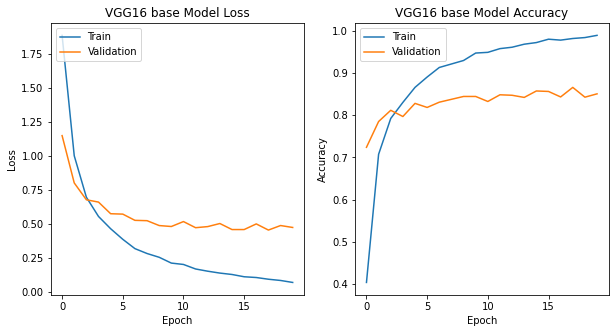

In [ ]:
# Loss and Accuracy plots of VGG16 pre-trained model
fig = plt.gcf()
fig.set_size_inches(10,5)
plt.subplot(1,2,1)
plt.plot(vgg16_hist.history['loss'])
plt.plot(vgg16_hist.history['val_loss'])
plt.title('VGG16 base Model Loss')
plt.ylabel('Loss')

plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplot(1,2,2)
plt.plot(vgg16_hist.history['accuracy'])
plt.plot(vgg16_hist.history['val_accuracy'])
plt.title('VGG16 base Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

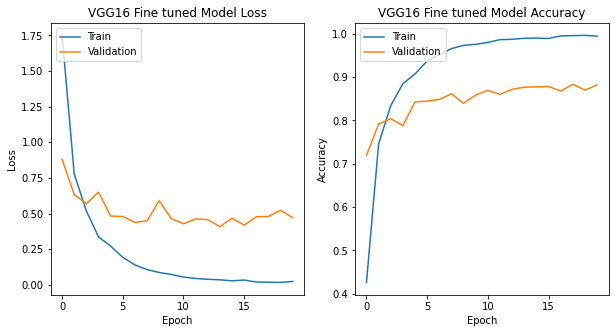

In [ ]:
# Loss and Accuracy plots of VGG16 fine tuned model
fig = plt.gcf()
fig.set_size_inches(10,5)
plt.subplot(1,2,1)
plt.plot(vgg16_ft_hist.history['loss'])
plt.plot(vgg16_ft_hist.history['val_loss'])
plt.title('VGG16 Fine tuned Model Loss')
plt.ylabel('Loss')

plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplot(1,2,2)
plt.plot(vgg16_ft_hist.history['accuracy'])
plt.plot(vgg16_ft_hist.history['val_accuracy'])
plt.title('VGG16 Fine tuned Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Comparison of Resnet101 and VGG16

ResNet101 Base model : 44.8%<br>
ResNet101 Fine tuned model : 54.4%<br>
VGG16 Base model : 87.3%<br>
VGG16 Fine tuned model : 90.1%

The ResNet101 model is not able to perform well for this particular dataset. Although, unfreezing few layers does have a positive effect on performance.<br>
The VGG16 model performs well for this data and gives decent accuracy. Unfreezing few portions of this pre-trained model has a slight increase in accuracy.